In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

In [ ]:
#Import data
!curl -L -o /content/archive.zip \
https://www.kaggle.com/api/v1/datasets/download/prajwalbhamere/car-damage-severity-dataset

!unzip /content/archive.zip -d /content/dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 13.7M  100 13.7M    0     0  15.9M      0 --:--:-- --:--:-- --:--:--  261M
Archive:  /content/archive.zip
  inflating: /content/dataset/data3a/training/01-minor/0001.JPEG  
  inflating: /content/dataset/data3a/training/01-minor/0002.JPEG  
  inflating: /content/dataset/data3a/training/01-minor/0003.JPEG  
  inflating: /content/dataset/data3a/training/01-minor/0004.JPEG  
  inflating: /content/dataset/data3a/training/01-minor/0005.JPEG  
  inflating: /content/dataset/data3a/training/01-minor/0006.JPEG  
  inflating: /content/dataset/data3a/training/01-minor/0007.JPEG  
  inflating: /content/dataset/data3a/training/01-minor/0008.JPEG  
  inflating: /content/dataset/data3a/training/01-minor/0009.JPEG  
  inflating: /content/dataset/data3a/training/01-m

In [ ]:
# Parameters
IMG_SIZE = (224, 224)
NUM_CLASSES = 3

# Function to load data from a directory
def load_data_from_directory(directory):
    images = []
    labels = []
    class_names = sorted(os.listdir(directory))  # Folder names represent classes
    class_indices = {class_name: idx for idx, class_name in enumerate(class_names)}

    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            try:
                # Load and preprocess the image
                img = load_img(img_path, target_size=IMG_SIZE)
                img_array = img_to_array(img)  # Convert to NumPy array
                images.append(img_array)
                labels.append(class_indices[class_name])
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")

    # Convert lists to NumPy arrays
    images = np.array(images, dtype='float32') / 255.0  # Normalize pixel values
    labels = np.array(labels)

    return images, labels

# Load training and validation data
train_dir = "/content/dataset/data3a/training"  # Update with your train folder path
val_dir = "/content/dataset/data3a/validation"      # Update with your val folder path

X_train, y_train = load_data_from_directory(train_dir)
X_val, y_val = load_data_from_directory(val_dir)

# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=NUM_CLASSES)
y_val = to_categorical(y_val, num_classes=NUM_CLASSES)

# Print the shapes of the arrays
print(f"Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, Validation labels shape: {y_val.shape}")

Training data shape: (1383, 224, 224, 3), Training labels shape: (1383, 3)
Validation data shape: (248, 224, 224, 3), Validation labels shape: (248, 3)


In [ ]:
# Building the VGG16 model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg16_base.trainable = False

model = Sequential([
    vgg16_base,
    Flatten(),
    Dense(512,activation='relu'),
    Dropout(0.6),
    Dense(256,activation='relu'),
    Dropout(0.6),
    Dense(NUM_CLASSES, activation='softmax')
])

# Compiling the model
model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

#Defining early stopping
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=7,  restore_best_weights=True)

# Training the model
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val), batch_size=32, callbacks=[es])

# Save the model
model.save('trained_model.h5')

# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,692,355 (105.64 MB)

 Trainable params: 12,977,667 (49.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step - accuracy: 0.3378 - loss: 1.6806 - val_accuracy: 0.4315 - val_loss: 1.0333
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.3974 - loss: 1.2712 - val_accuracy: 0.6250 - val_loss: 0.9748
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.4064 - loss: 1.1334 - val_accuracy: 0.6331 - val_loss: 0.9490
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.4482 - loss: 1.0836 - val_accuracy: 0.6855 - val_loss: 0.9263
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.4542 - loss: 1.0471 - val_accuracy: 0.7097 - val_loss: 0.8875
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.4625 - loss: 1.0041 - val_accuracy: 0.7258 - val_loss: 0.8569
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.5559 - loss: 0.9466 - val_accuracy: 0.7056 - val_loss: 0.8287
Epoch 8/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.5583 - loss: 0.9267 - val_accuracy: 0.7218 -

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.7497 - loss: 0.7333
Validation Accuracy: 74.19%


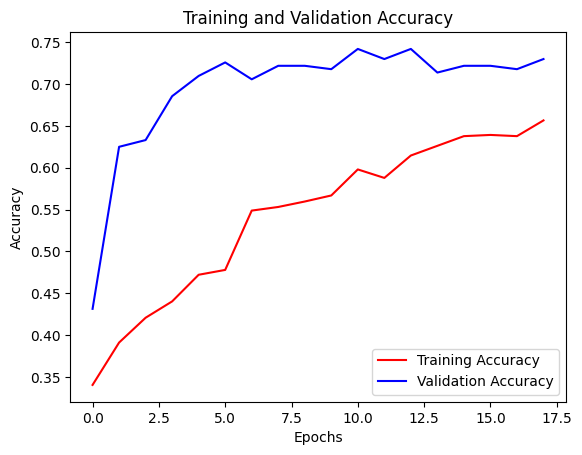

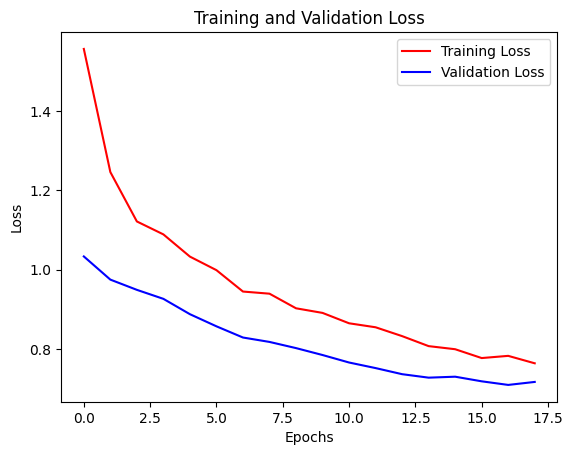

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step


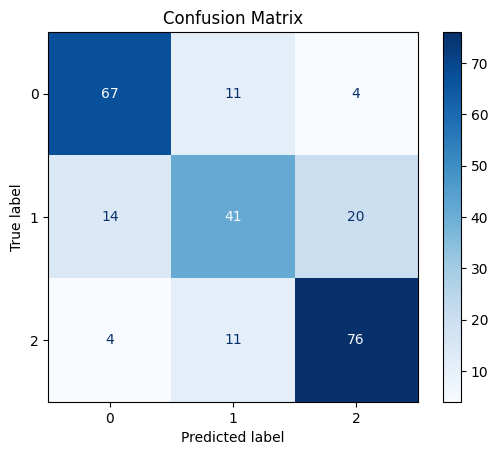

In [ ]:
# Loss curve visualization and confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Plot Accuracy and Loss Curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# Accuracy plot
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# Loss plot
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Confusion Matrix
# Get predictions from the model
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(NUM_CLASSES))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import pandas as pd

# Extract training history
history_dict = history.history

# Convert to DataFrame
history_df = pd.DataFrame(history_dict)

# Save to CSV
history_df.to_csv('training_history.csv', index=False)


In [ ]:
#Inference code
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Load the trained model
model = load_model('trained_model.h5')

# Function to preprocess the image
def preprocess_image(image_path):
    IMG_SIZE = (224, 224)
    img = load_img(image_path, target_size=IMG_SIZE)
    img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Define class names
class_names = ['minor', 'moderate', 'severe']

# Path to the input image
image_path = '/content/Test image.jpg'

# Preprocess the image
preprocessed_image = preprocess_image(image_path)

# Predict
predictions = model.predict(preprocessed_image)
predicted_class = np.argmax(predictions, axis=1)
predicted_class_name = class_names[predicted_class[0]]

print(f"Predicted Class Index: {predicted_class[0]}")
print(f"Predicted Class Name: {predicted_class_name}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
Predicted Class Index: 0
Predicted Class Name: minor
